In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [3]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
BATCH_SIZE = 4

# 1. Dataset

In [4]:
from helpers.datasets import MnMsDataset, MnMsHDF5Dataset
from helpers.utils import get_transforms

In [5]:
# transforms = get_transforms()
# data_path_root = "./data/MnMs_extracted/"
# train_dataset = MnMsDataset("csf", data_path_root, transforms, "train")
# eval_dataset = MnMsDataset("csf", data_path_root, transforms, "eval")
# test_dataset = MnMsDataset("csf", data_path_root, transforms, "test")
# print(f"{len(train_dataset)}, {len(eval_dataset)}, {len(test_dataset)}")

In [6]:
transforms = get_transforms()
data_path_root = "./data/MnMs_extracted/MnMs_extracted.h5"
train_dataset = MnMsHDF5Dataset(data_path_root, "csf", "train", transforms)
eval_dataset = MnMsHDF5Dataset(data_path_root, "csf", "eval", transforms)
test_dataset = MnMsHDF5Dataset(data_path_root, "csf", "test", transforms)
print(f"{len(train_dataset)}, {len(eval_dataset)}, {len(test_dataset)}")

612, 206, 168


556


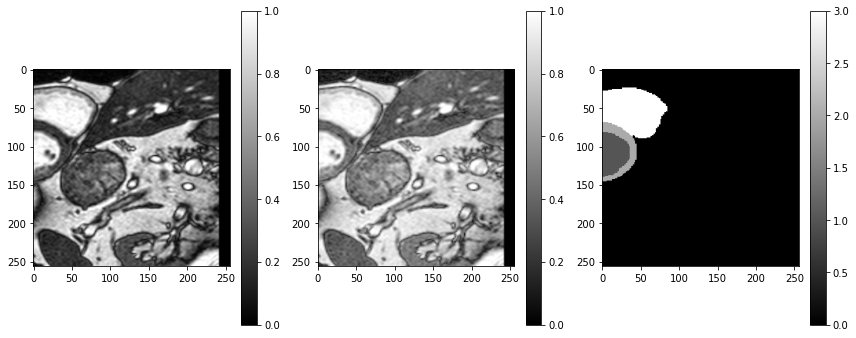

In [7]:
ind_test = np.random.randint(len(train_dataset))
print(ind_test)
# ind_test = 110
img, img1, mask = train_dataset[ind_test]
train_dataset.plot_triple(img[0], img1[0], mask[0], figsize=(12, 4.8))

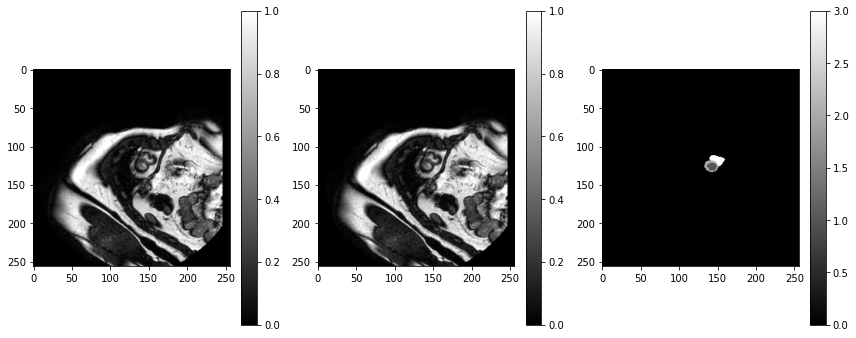

In [8]:
eval_ind = np.random.randint(len(eval_dataset))
img, mask = eval_dataset[eval_ind]
eval_dataset.plot_triple(img[0], img[0], mask[0], figsize=(12, 4.8))

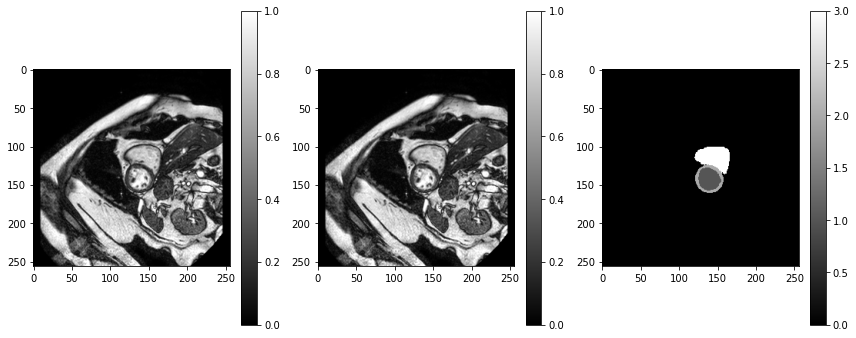

In [9]:
test_ind = np.random.randint(len(test_dataset))
img, mask = test_dataset[test_ind]
test_dataset.plot_triple(img[0], img[0], mask[0], figsize=(12, 4.8))

In [10]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [11]:
for img, img1, mask in train_loader:
    print(f"{img.shape}, {img1.shape}, {mask.shape}")
    break

for img, mask in eval_loader:
    print(f"{img.shape}, {mask.shape}")
    break

for img, mask in test_loader:
    print(f"{img.shape}, {mask.shape}")
    break

torch.Size([4, 1, 256, 256]), torch.Size([4, 1, 256, 256]), torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256]), torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256]), torch.Size([4, 1, 256, 256])


# 2. Model

In [12]:
DEVICE = torch.device("cpu")

In [13]:
from models.modules import Normalizer
from models.u_net import UNet

In [14]:
normalizer = Normalizer().to(DEVICE)
u_net = UNet(num_down_blocks=4, target_channels=4, in_channels=1).to(DEVICE)

In [15]:
norm_opt = torch.optim.Adam(normalizer.parameters())
u_net_opt = torch.optim.Adam(u_net.parameters())

# 3. Training

In [16]:
from helpers.train_eval import AlternatingTrainer, TestTimeAdapter

In [17]:
time_stamp = f"{time.time()}".replace(".", "_")
time_stamp

'1639349559_363759'

In [18]:
writer = SummaryWriter(f"run/norm_u_net/{time_stamp}")

In [19]:
alt_trainer = AlternatingTrainer(normalizer, u_net, train_loader, eval_loader, test_loader, norm_opt, u_net_opt, 
                                 ce_weight=0.5, dsc_weight=0.5, device=DEVICE, epochs=3, 
                                 writer=writer, time_stamp=time_stamp)
mode_save_dir = "./params/norm_u_net/"

In [21]:
# train_losses, eval_losses = alt_trainer.train(mode_save_dir)

# 4 .Evaluation

In [16]:
import os
from helpers.utils import make_summary_plot

In [17]:
DEVICE = torch.device("cuda")

In [64]:
u_net_param = "./params/norm_u_net/1639396787_863887/u_net_ce_0_0_dsc_1_0_epoch_20_eval_loss_0_0221.pt"
norm_param = "./params/norm_u_net/1639396787_863887/norm_ce_0_0_dsc_1_0_epoch_20_eval_loss_0_0221.pt"

In [65]:
normalizer = Normalizer().to(DEVICE)
u_net = UNet(num_down_blocks=4, target_channels=4, in_channels=1).to(DEVICE)

In [66]:
u_net.load_state_dict(torch.load(u_net_param))
u_net.eval()
print(end="")

In [67]:
normalizer.load_state_dict(torch.load(norm_param))
normalizer.eval()
print(end="")

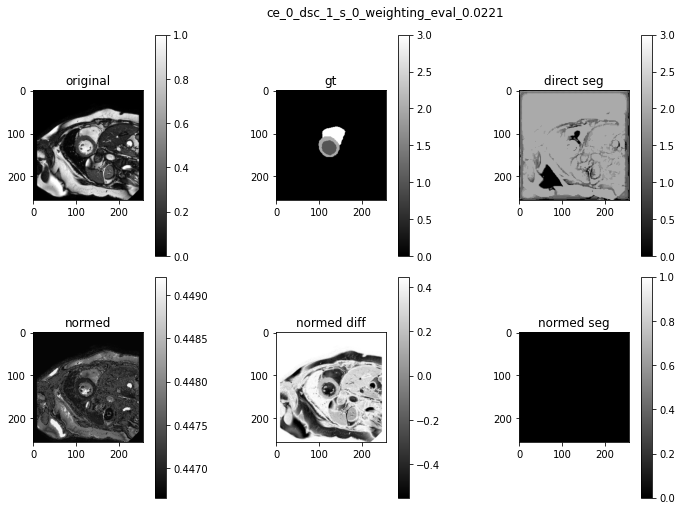

In [72]:
fig = make_summary_plot(u_net, normalizer, test_loader, "./out_images/AlternatingTrainer/ce_0_dsc_1_s_0_weight_new.png", 
                        "ce_0_dsc_1_s_0_weighting_eval_0.0221", figsize=(10.8, 7.2), fraction=0.5)

In [21]:
# test_ind = np.random.randint(len(test_dataset))
# img, mask = test_dataset[test_ind]
# test_dataset.plot_triple(img[0], img[0], mask[0], figsize=(12, 4.8))

In [22]:
# ind_test = np.random.randint(len(train_dataset))
# print(ind_test)
# # ind_test = 110
# img, img1, mask = train_dataset[ind_test]
# train_dataset.plot_triple(img[0], img1[0], mask[0], figsize=(12, 4.8))

In [23]:
# img.shape, mask.dtype

In [24]:
# X = img.to(DEVICE).unsqueeze(0)
# # X = normalizer(X)
# mask_pred = u_net(X)
# X.shape, mask_pred.shape

In [25]:
# plt.imshow(mask_pred.argmax(dim=1)[0].detach().cpu().numpy(), cmap="gray")
# plt.colorbar()

In [26]:
# X = normalizer(X)
# plt.imshow(X[0, 0].detach().cpu().numpy(), cmap="gray")
# plt.colorbar()

In [27]:
# X_out = ((X[0, 0].detach().cpu().numpy()) + 1) / 2
# plt.imshow(X_out - img[0].numpy(), cmap="gray")
# plt.colorbar()